# Lab 4 - Aspect-Based Sentiment Analysis



---















In this session, we demonstrate how to deal with the aspect-based sentiment analysis (ABSA). You can find the whole task description from (https://aclanthology.org/D19-1654.pdf).
This task provides a review text dataset with aspect.
Given a review and an aspect, we need to classify the sentiment conveyed towards that aspect on a  three-point scale:   POSITIVE, NEUTRAL, and NEGATIVE.
This is a multi-class classification task, and it needs to analyze the text and its aspect. 

Same as before, we are going to use Keras Sequential API in this session. The Sequential API allows you to make models layer-by-layer. You could modify the previous models to fit in the new task.

In [ ]:
import keras
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras import backend as K
from keras.models import Sequential
import matplotlib.pyplot as plt

from keras.layers import LSTM, RNN, Dropout, Input, LeakyReLU, Bidirectional,Conv1D, GlobalMaxPooling1D, Dot
from keras.layers.core import Dense
from keras.models import Model

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


### Downloading and preprocessing data

Unlike the IMDB dataset that is included and preprocessed by the Keras, the dataset we will be using is the aspect-term sentiment analysis (ATSA) dataset, which consists of 5297 labeled reviews. These are split into 4,297 reviews for training and 500 reviews for testing and validation, respectively. 

For ATSA, the annotators extract aspect terms in the sentences and label the sentiment polarities with respect to the  aspect  terms.   The  sentences  that  consist  of only one aspect term or multiple aspects with the same  sentiment  polarities  are  deleted.  ATSA also provides the start and end positions in a sentence for each aspect term.

In [ ]:
import requests
def downloadfile(url):
  rq = requests.get(url)
  open(url.split('/')[-1], 'wb').write(rq.content)
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/train.xml')
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/val.xml')
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/test.xml')


In [ ]:
# The code is modified from https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data_process/utils.py
from xml.etree.ElementTree import parse

def parse_sentence_term(path, lowercase=False):
    tree = parse(path)
    sentences = tree.getroot()
    data = []
    split_char = '__split__'
    for sentence in sentences:
        text = sentence.find('text')
        if text is None:
            continue
        text = text.text
        if lowercase:
            text = text.lower()
        aspectTerms = sentence.find('aspectTerms')
        if aspectTerms is None:
            continue
        for aspectTerm in aspectTerms:
            term = aspectTerm.get('term')
            if lowercase:
                term = term.lower()
            polarity = aspectTerm.get('polarity')
            start = aspectTerm.get('from')
            end = aspectTerm.get('to')
            piece = [text , term,  polarity , start , end]
            data.append(piece)
    return data
train = parse_sentence_term("train.xml",True)
val = parse_sentence_term("val.xml",True)
test = parse_sentence_term("test.xml",True)

print("Training entries: {}".format(len(train)))
print("Test entries: {}".format(len(test)))

Training entries: 11186
Test entries: 1336


We now can start playing around with the data, let’s first see some examples:

In [ ]:
print("SENTENCE \t ASPECT \t LABEL \t ASPECT-START-INDEX \t ASPECT-END-INDEX")
print(train[0])
print(train[1])
print(train[2])
print(train[3])
print(train[4])

SENTENCE 	 ASPECT 	 LABEL 	 ASPECT-START-INDEX 	 ASPECT-END-INDEX
['the decor is not special at all but their food and amazing prices make up for it.', 'decor', 'negative', '4', '9']
['the decor is not special at all but their food and amazing prices make up for it.', 'food', 'positive', '42', '46']
['the decor is not special at all but their food and amazing prices make up for it.', 'prices', 'positive', '59', '65']
['when tables opened up, the manager sat another party before us.', 'tables', 'neutral', '5', '11']
['when tables opened up, the manager sat another party before us.', 'manager', 'negative', '27', '34']


We could use this dataset to try an "unknown aspect" task, if we assume that the ASPECT, LABEL and START/END-INDEX fields are what the model must predict. But here we will attempt a simpler "known aspect" task: we will assume that we know ASPECT and START/END-INDEX and the model must just predict the LABEL for a given combination of aspect and sentence.

First, build a vocabulary based on the training dataset. 

In [ ]:
voc = []
from keras.preprocessing.text import text_to_word_sequence
for example in train:
  text_tokens = text_to_word_sequence(example[0])
  aspect_tokens = text_to_word_sequence(example[1])
  voc.extend(aspect_tokens)
  voc.extend(text_tokens)
voc = set(voc)
print(len(voc))

word_index = dict()
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  
word_index["<EOS>"] = 3
for w in voc:
  word_index[w] = len(word_index)
print(len(word_index))

7894
7898


According to the word_index and the tokenizer function (text_to_word_sequence), we can convert the review text and aspect words to word tokens and integers separately:


In [ ]:
# Please write your code to generate the following data
x_train_review = [text_to_word_sequence(x[0]) for x in train]
x_train_aspect = [text_to_word_sequence(x[1]) for x in train]
x_train_review_int = [[word_index[word] for word in sent] for sent in x_train_review]
x_train_aspect_int = [[word_index[word] for word in tok] for tok in x_train_aspect]

x_dev_review = [text_to_word_sequence(x[0]) for x in val]
x_dev_aspect = [text_to_word_sequence(x[1]) for x in val]
x_dev_review_int = [[word_index[word] if word in word_index.keys() else word_index["<UNK>"] for word in sent ] for sent in x_dev_review]
x_dev_aspect_int = [[word_index[word] if word in word_index.keys() else word_index["<UNK>"] for word in tok] for tok in x_dev_aspect]

x_test_review = [text_to_word_sequence(x[0]) for x in test]
x_test_aspect = [text_to_word_sequence(x[1]) for x in test]
x_test_review_int = [[word_index[word] if word in word_index.keys() else word_index["<UNK>"] for word in sent] for sent in x_test_review]
x_test_aspect_int = [[word_index[word] if word in word_index.keys() else word_index["<UNK>"] for word in tok] for tok in x_test_aspect]

# your code goes here:



# If use the previous word_index, you can get a print result like:
assert len(x_train_aspect) == len(train)
assert len(x_train_aspect) == len(x_train_aspect_int)
assert len(x_test_aspect) == len(test)
assert len(x_test_aspect) == len(x_test_aspect_int)
print("x_train_review[0]:")
print(x_train_review[0])
print("x_train_aspect[0]:")
print(x_train_aspect[0])
print("x_train_review_int[0]:")
print(x_train_review_int[0])
print("x_train_aspect_int[0]:")
print(x_train_aspect_int[0])

x_train_review[0]:
['the', 'decor', 'is', 'not', 'special', 'at', 'all', 'but', 'their', 'food', 'and', 'amazing', 'prices', 'make', 'up', 'for', 'it']
x_train_aspect[0]:
['decor']
x_train_review_int[0]:
[4612, 4202, 1669, 5313, 4283, 5627, 4998, 6492, 7607, 4980, 2218, 5752, 6150, 5978, 5002, 528, 1208]
x_train_aspect_int[0]:
[4202]




We use 4 to represent "positive", 2 for "neutral", and 1 for "negative". Then we can convert the lables to numbers.

In [ ]:
def label2int(dataset):
  y = []
  for example in dataset:
    if example[2].lower() == "negative":
      y.append([0,0,1])
    elif example[2].lower() == "neutral":
      y.append([0,1,0])
    else:
      # assert example[2].lower() == "positive"
      y.append([1,0,0])
  return y
  
y_train = label2int(train)
y_dev = label2int(val)
y_test = label2int(test)
y_train = np.array(y_train)
y_dev = np.array(y_dev)
y_test = np.array(y_test)

print(y_train[0])
print(y_train[1])
print(y_train[2])
print(y_train[3])
print(y_train[4])

[0 0 1]
[1 0 0]
[1 0 0]
[0 1 0]
[0 0 1]


Now we have almost done the data preprocessing. Unlike the previous lab, there are two x (review and aspect) to input the model in here. The easiest way is to combine the review and aspect into one sentence and then input it into the model. Thus we can use the previous model directly.

(This means our model is similar to a simplified version of the Vo & Zhang model from the lectures: we have an input sequence containing an aspect embedding paired with the sentence word embeddings (but not separating into left & right sentence context as Vo & Zhang do).

In [ ]:
# Please write your code to combine the x_*_review and x_*_aspect into the following varibles
x_train = [aspect + ["<START>"] + sent_tok for aspect, sent_tok in zip(x_train_aspect, x_train_review)]
x_train_int = [[word_index[word] for word in sent] for sent in x_train]
x_dev = [aspect + ["<START>"] + sent_tok for aspect, sent_tok in zip(x_dev_aspect, x_dev_review)]
x_dev_int = [[word_index[word] if word in word_index.keys() else word_index["<UNK>"] for word in sent] for sent in x_dev]
x_test = [aspect + ["<START>"] + sent_tok for aspect, sent_tok in zip(x_test_aspect, x_test_review)]
x_test_int = [[word_index[word] if word in word_index.keys() else word_index["<UNK>"] for word in sent] for sent in x_test]

# your code goes here
from keras.preprocessing.sequence import pad_sequences
MAX_LENGHT = 128
x_train_pad = pad_sequences(x_train_int, maxlen= MAX_LENGHT, padding= 'post')
x_dev_pad = pad_sequences(x_dev_int, maxlen= MAX_LENGHT, padding= 'post')
x_test_pad = pad_sequences(x_test_int, maxlen= MAX_LENGHT, padding= 'post')
# Tips: 
# 1) We can use the special token <START> to concatenate the reviews and aspects.
# 2) After combine them, do not foget to pad the sequences.


# Don't forget the to use np.array function to wrap the ouput of pad_sequences function, such as: x_train_pad = np.array(x_train_pad)
# Only pad the *_int varibles
print("Before paded:")
print(x_train[0])
print(x_train_int[0])
print("After paded:")
print(x_train_pad[0])

Before paded:
['decor', '<START>', 'the', 'decor', 'is', 'not', 'special', 'at', 'all', 'but', 'their', 'food', 'and', 'amazing', 'prices', 'make', 'up', 'for', 'it']
[4202, 1, 4612, 4202, 1669, 5313, 4283, 5627, 4998, 6492, 7607, 4980, 2218, 5752, 6150, 5978, 5002, 528, 1208]
After paded:
[4202    1 4612 4202 1669 5313 4283 5627 4998 6492 7607 4980 2218 5752
 6150 5978 5002  528 1208    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


#Model 1: Previous models without pre-trained word embeddings

## Model 1-1: Neural bag of words without pre-trained word embeddings

Now we use the model2 in lab4 to deal with our task. However, the previous model works only for the binary classification task. Therefore, we need to modify the output layer to fix the multi-class problem. You can read this tutorial for more details: https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)


In [ ]:
type(y_dev)

numpy.ndarray

In [ ]:
# your code goes here
# Tips: The activation function of the output layer is softmax.
VOCAB_SIZE = len(word_index)
EMBED_SIZE = 100
input = Input((128, ), dtype= 'int32')

model = Embedding(VOCAB_SIZE, EMBED_SIZE, input_length= MAX_LENGHT, name= "Embeddings")(input)

model = (GlobalAveragePooling1DMasked())(model)

model = (Dense(16, activation="relu", name= "Hidden_1"))(model)

model = (Dense(3, activation="sigmoid", name= "Output"))(model)

model = Model(input, model , name = "Model_2_Learning_Embeddings")

model.summary()

model.compile(optimizer='adam',
              loss= keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

x_train_pad = np.array(x_train_pad)
y_train = np.array(y_train)
x_dev_pad = np.array(x_dev_pad)
y_dev = np.array(y_dev)
history = model.fit(x_train_pad,
                    y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_dev_pad, y_dev),
                    verbose=1)

results = model.evaluate(x_test_pad, y_test)
print(results)

Model: "Model_2_Learning_Embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 Embeddings (Embedding)      (None, 128, 100)          789800    
                                                                 
 global_average_pooling1d_ma  (None, 100)              0         
 sked (GlobalAveragePooling1                                     
 DMasked)                                                        
                                                                 
 Hidden_1 (Dense)            (None, 16)                1616      
                                                                 
 Output (Dense)              (None, 3)                 51        
                                                                 
Total params: 791,467
Trainable params:

The accuracy of lab3 model2 in this task is around 46%. If you use the "glorot_uniform" initialization method, the accuracy can reach around 55%.

##  Model 1-2: CNN or LSTM without pre-trained word embeddings

Please try one more model (CNN or LSTM) without pre-trained word embeddings in here:

In [ ]:
# Try CNN or LSTM without pre-trained word embeddings in here:

from keras.layers.recurrent_v2 import LSTM
# your code goes here
input = Input((128, ), dtype= 'int32')

model1_2 = Embedding(VOCAB_SIZE, EMBED_SIZE, input_length= MAX_LENGHT, name= "Embeddings")(input)

model1_2 = LSTM(100, return_sequences=False)(model1_2)

model1_2 = (Dense(16, activation="relu"))(model1_2)

model1_2 = (Dense(3, activation="sigmoid"))(model1_2)

model1_2 = Model(input, model1_2)

model1_2.summary()

model1_2.compile(optimizer='adam',
              loss= keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

x_train_pad = np.array(x_train_pad)
y_train = np.array(y_train)
x_dev_pad = np.array(x_dev_pad)
y_dev = np.array(y_dev)
history = model1_2.fit(x_train_pad,
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=(x_dev_pad, y_dev),
                    verbose=1)

results = model1_2.evaluate(x_test_pad, y_test)
print(results)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 Embeddings (Embedding)      (None, 128, 100)          789800    
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 16)                1616      
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 871,867
Trainable params: 871,867
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
22/22 [==============================] - 19s

# Model 2: Using pre-trained word embeddings

### Preparing pre-trained word embeddings (GLOVE)

The Embedding layer can be used to load a pre-trained word embedding model. We are going to use GloVe embeddings, which you can read about it here (https://nlp.stanford.edu/projects/glove/). GloVe stands for "Global Vectors for Word Representation". It's a somewhat popular embedding technique based on factorizing a matrix of word co-occurence statistics. You can download GloVe and we can seed the Keras Embedding layer with weights from the pre-trained embedding for the words in your dataset.
First, we need to read GloVe and map words to GloVe:


In [ ]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

Now, we create our pre-trained Embedding layer:

In [ ]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name = 'GloVe_Embeddings')
    return embeddingLayer

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'

--2022-03-14 22:29:41--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-14 22:29:42--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-14 22:29:42--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

We freeze the weights. To create the model: 

In [ ]:
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.50d.txt')
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.100d.txt')
wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.300d.txt')

# vocabLen = len(wordToIndex) + 1 

EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)

Size of Embedding:  300


### Convert the data to GLOVE word index

The index in our vocabulary is different from that in GLOVE. For example, the word "you" corresponds to 394475 in GLOVE, while it corresponds to another index in our vocabulary. Thus we can not directly use the index data in the last section. We convert them from text tokens to GLOVE word index.

In [ ]:
print(wordToIndex["you"])
print(indexToWord[394475])
print(word_index["you"])

394475
you
6695


In [ ]:
# Please write your code to generate the following data
x_train_review_glove = [ [wordToIndex[word] if word in wordToIndex else wordToIndex['unk'] for word in sent] for sent in x_train_review]
x_train_aspect_glove = [[wordToIndex[word] if word in wordToIndex else wordToIndex['unk'] for word in sent] for sent in x_train_aspect]

x_dev_review_glove = [[wordToIndex[word] if word in wordToIndex else wordToIndex['unk'] for word in sent] for sent in x_dev_review]
x_dev_aspect_glove =[[wordToIndex[word] if word in wordToIndex else wordToIndex['unk'] for word in sent] for sent in x_dev_aspect]

x_test_review_glove = [[wordToIndex[word] if word in wordToIndex else wordToIndex['unk'] for word in sent] for sent in x_test_review]
x_test_aspect_glove = [[wordToIndex[word] if word in wordToIndex else wordToIndex['unk'] for word in sent] for sent in x_test_aspect]

# your code goes here


# You should get a print result like:
assert len(x_train_review_glove) == len(train)
assert len(x_train_aspect_glove) == len(x_train_aspect_int)
assert len(x_test_review_glove) == len(test)
assert len(x_test_aspect_glove) == len(x_test_aspect_int)
print("x_train_review_glove[0]:")
print(x_train_review_glove[0])
print("x_train_aspect_glove[0]:")
print(x_train_aspect_glove[0])

x_train_review_glove[0]:
[357266, 118926, 192973, 264550, 338995, 62065, 51582, 87775, 357354, 151204, 54718, 53201, 292136, 231458, 373317, 151349, 193716]
x_train_aspect_glove[0]:
[118926]


As before, we concatenate the tweets and topics for fitting in the previous model. Let us do it again for GLOVE version variables.

In [ ]:
# Please write your code to combine the x_*_review_glove and x_*_aspect_glove into the following varibles
# x_train_glove
# x_dev_glove
# x_test_glove

# Tips: 
# 1) There is no <START> token in GLOVE. Here we can use integer 1 to concatenate.
# 2) After combine them, do not foget to pad the sequences.

#######################TODO: REMOVE FOLLOWING CODE#####################
def combine_x(x_train_aspect, x_train_review):
  te = [aspect + [1] + sent_tok for aspect, sent_tok in zip(x_train_aspect, x_train_review)]
  return te

x_train_glove = combine_x(x_train_aspect_glove,x_train_review_glove)
x_dev_glove   = combine_x(x_dev_aspect_glove  ,x_dev_review_glove)
x_test_glove  = combine_x(x_test_aspect_glove ,x_test_review_glove)
print(x_train_glove[0])

x_train_pad_glove = keras.preprocessing.sequence.pad_sequences(x_train_glove,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=128)

x_dev_pad_glove = keras.preprocessing.sequence.pad_sequences(x_dev_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=128)

x_test_pad_glove = keras.preprocessing.sequence.pad_sequences(x_test_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=128)
x_train_pad_glove = np.array(x_train_pad_glove)
x_dev_pad_glove = np.array(x_dev_pad_glove)
x_test_pad_glove = np.array(x_test_pad_glove)
#######################TODO: REMOVE ABOVE CODE####################

# Don't forget the to use np.array function to wrap the ouput of pad_sequences function, such as: x_train_pad = np.array(x_train_pad)
# Only pad the *_int varibles
print("Before paded:")
print(x_train_glove[0])
print("After paded:")
print(x_train_pad_glove[0])

[118926, 1, 357266, 118926, 192973, 264550, 338995, 62065, 51582, 87775, 357354, 151204, 54718, 53201, 292136, 231458, 373317, 151349, 193716]
Before paded:
[118926, 1, 357266, 118926, 192973, 264550, 338995, 62065, 51582, 87775, 357354, 151204, 54718, 53201, 292136, 231458, 373317, 151349, 193716]
After paded:
[118926      1 357266 118926 192973 264550 338995  62065  51582  87775
 357354 151204  54718  53201 292136 231458 373317 151349 193716      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      

## Model 2-1: Neural bag of words using pre-trained word embeddings

We use model3-1 in lab4 to deal with this task.

In [ ]:
# your code goes here
# Tips: Do not misuse the training data
input = Input((128, ), dtype= 'int32')

model3 = embeddingLayer(input)

model3 = (GlobalAveragePooling1DMasked())(model3)

model3 = (Dense(16, activation="relu"))(model3)

model3 = (Dense(3, activation="softmax"))(model3)

model3 = Model(input, model3)
model3.summary()
model3.compile(optimizer='adam',
              loss= keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history = model3.fit(x_train_pad_glove,
                    y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_dev_pad_glove, y_dev),
                    verbose=1)

results = model3.evaluate(x_test_pad, y_test)
print(results)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 128, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked_1 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_2 (Dense)             (None, 16)                4816      
                                                                 
 dense_3 (Dense)             (None, 3)                 51        
                                                           

The accuracy is around 56%. In this version, the "glorot_uniform" initialization method does not improve model performance significantly.

##  Model 2-2: CNN or LSTM with pre-trained word embeddings

Please try one more model (CNN or LSTM) with pre-trained word embeddings in here:

In [ ]:
# your code goes here
from keras.layers.recurrent_v2 import LSTM
# your code goes here
input = Input((128, ), dtype= 'int32')

model7 = createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, False)(input)

model7 = LSTM(100, return_sequences=False)(model7)

model7 = (Dense(3, activation="softmax"))(model7)

model7 = Model(input, model7)

model7.summary()

model7.compile(optimizer='adam',
              loss= keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model7.fit(x_train_pad_glove,
                    y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_dev_pad_glove, y_dev),
                    verbose=1)

results = model7.evaluate(x_test_pad, y_test)
print(results)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 128, 300)         120000300 
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense_4 (Dense)             (None, 3)                 303       
                                                                 
Total params: 120,161,003
Trainable params: 160,703
Non-trainable params: 120,000,300
_________________________________________________________________
Epoch 1/40
22/22 [==============================] - 21s 852ms/step - loss: 1.0775 - accuracy: 0.4439 - va

#  Model 3: Model with multiple-input

Model 1 and 2 are copied from lab4. We build new models in this section. 

In models 1 and 2, we combine the reviews and aspects to input into the models. In model 3, we separately input these two data into the model and use different layers to analyze them. 

(This will give us a model similar to a simplified version of the Xue & Li model from the lectures - we have a separate paths through the network for the aspect embedding and the sentence, being combined - but we don't have to use gating like Xue & Li).

In [ ]:
# First of all, pad the review and aspect separately
x_train_review_pad_glove = keras.preprocessing.sequence.pad_sequences(x_train_review_glove,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=128)

x_dev_review_pad_glove = keras.preprocessing.sequence.pad_sequences(x_dev_review_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=128)

x_test_review_pad_glove = keras.preprocessing.sequence.pad_sequences(x_test_review_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=128)

x_train_aspect_pad_glove = keras.preprocessing.sequence.pad_sequences(x_train_aspect_glove,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=16)

x_dev_aspect_pad_glove = keras.preprocessing.sequence.pad_sequences(x_dev_aspect_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=16)

x_test_aspect_pad_glove = keras.preprocessing.sequence.pad_sequences(x_test_aspect_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=16)

## Model 3-1 Neural bag of words model with multiple-input

Model 3-1 needs you to modify the model 2-1 to be compatible with multiple-input.
You could find some tutorial examples from (https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/).

Please print the model summary and visualize it using vis_utils.

In [ ]:
from keras.layers import concatenate
inputA = Input(shape=(16,))
inputB = Input(shape=(128,))
t = createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, False)

x = GlobalAveragePooling1DMasked()(t(inputA))
x = (Dense(16, activation="relu"))(x)

y = GlobalAveragePooling1DMasked()(t(inputB))
y = (Dense(16, activation="relu"))(y)


combined = concatenate([x, y])
z = Dense(3, activation="sigmoid")(combined)
model31 = Model(inputs=[inputA, inputB], outputs=z)


model31.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 GloVe_Embeddings (Embedding)   multiple             120000300   ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 global_average_pooling1d_maske  (None, 300)         0           ['GloVe_Embeddings[0][0]'] 

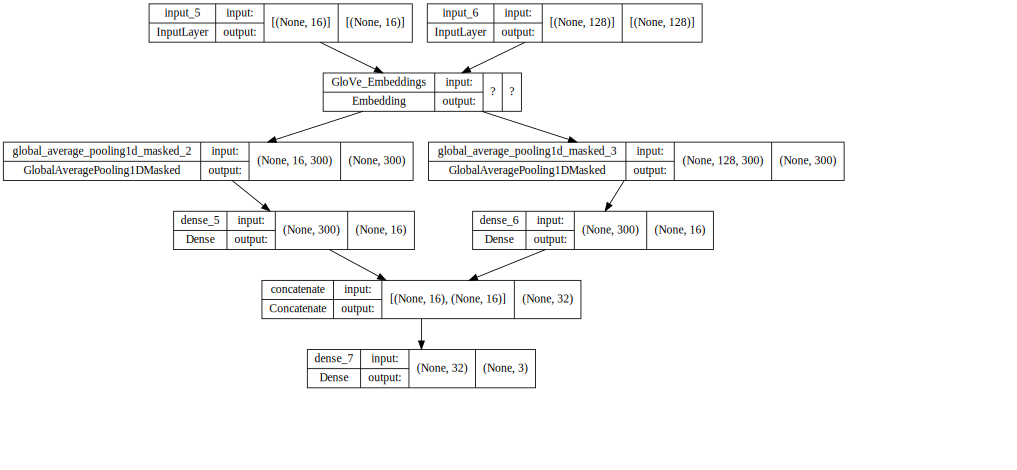

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model31, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  

Train and evaluate your model:

In [ ]:
# your code goes here

model31.compile(optimizer='adam',
              loss= keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model31.fit([x_train_aspect_pad_glove, x_train_review_pad_glove],
                    y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=([x_dev_aspect_pad_glove, x_dev_review_pad_glove], y_dev),
                    verbose=1)

results = model31.evaluate([x_test_aspect_pad_glove, x_test_review_pad_glove], y_test)
print(results)

Epoch 1/40
22/22 [==============================] - 2s 37ms/step - loss: 1.0858 - accuracy: 0.4009 - val_loss: 1.0603 - val_accuracy: 0.4535
Epoch 2/40
22/22 [==============================] - 1s 29ms/step - loss: 1.0488 - accuracy: 0.4507 - val_loss: 1.0306 - val_accuracy: 0.4535
Epoch 3/40
22/22 [==============================] - 1s 29ms/step - loss: 1.0238 - accuracy: 0.4515 - val_loss: 1.0054 - val_accuracy: 0.4572
Epoch 4/40
22/22 [==============================] - 1s 30ms/step - loss: 0.9982 - accuracy: 0.4742 - val_loss: 0.9779 - val_accuracy: 0.4902
Epoch 5/40
22/22 [==============================] - 1s 30ms/step - loss: 0.9708 - accuracy: 0.5157 - val_loss: 0.9491 - val_accuracy: 0.5548
Epoch 6/40
22/22 [==============================] - 1s 30ms/step - loss: 0.9428 - accuracy: 0.5667 - val_loss: 0.9213 - val_accuracy: 0.5766
Epoch 7/40
22/22 [==============================] - 1s 30ms/step - loss: 0.9177 - accuracy: 0.5838 - val_loss: 0.8988 - val_accuracy: 0.5856
Epoch 8/40
22

## Model 3-2 CNN or LSTM model with multiple-input

Modify the previous CNN or LSTM model to be compatible with multiple-input, similar to model 3-1. 

In [ ]:
# your code goes here
inputA = Input(shape=(16,))
inputB = Input(shape=(128,))

t = createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, False)

x = LSTM(100, return_sequences=False)(t(inputA))
y = LSTM(100, return_sequences=False)(t(inputB))
combined = concatenate([x, y])
model32 = (Dense(3, activation="sigmoid"))(combined)

model32 = Model([inputA, inputB], outputs= model32)

model32.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 GloVe_Embeddings (Embedding)   multiple             120000300   ['input_7[0][0]',                
                                                                  'input_8[0][0]']                
                                                                                                  
 lstm_2 (LSTM)                  (None, 100)          160400      ['GloVe_Embeddings[0][0]'] 

In [ ]:
model32.compile(optimizer='adam',
              loss= keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model32.fit([x_train_aspect_pad_glove, x_train_review_pad_glove],
                    y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=([x_dev_aspect_pad_glove, x_dev_review_pad_glove], y_dev),
                    verbose=1)

results = model32.evaluate([x_test_aspect_pad_glove, x_test_review_pad_glove], y_test)
print(results)

Epoch 1/40
22/22 [==============================] - 23s 899ms/step - loss: 1.0317 - accuracy: 0.4623 - val_loss: 0.9116 - val_accuracy: 0.5848
Epoch 2/40
22/22 [==============================] - 19s 858ms/step - loss: 0.8984 - accuracy: 0.5809 - val_loss: 0.8540 - val_accuracy: 0.6096
Epoch 3/40
22/22 [==============================] - 19s 857ms/step - loss: 0.8629 - accuracy: 0.6048 - val_loss: 0.8420 - val_accuracy: 0.6111
Epoch 4/40
22/22 [==============================] - 19s 853ms/step - loss: 0.8517 - accuracy: 0.6082 - val_loss: 0.8356 - val_accuracy: 0.6134
Epoch 5/40
22/22 [==============================] - 19s 857ms/step - loss: 0.8438 - accuracy: 0.6148 - val_loss: 0.8347 - val_accuracy: 0.6261
Epoch 6/40
22/22 [==============================] - 19s 854ms/step - loss: 0.8378 - accuracy: 0.6230 - val_loss: 0.8283 - val_accuracy: 0.6224
Epoch 7/40
22/22 [==============================] - 19s 858ms/step - loss: 0.8332 - accuracy: 0.6203 - val_loss: 0.8334 - val_accuracy: 0.6261

#  Model 4: Another LSTM model

If you study the data carefully, you can find that every aspect appears in the review sentence, which means we can extract the aspect information from the sentence. In most cases, the polarity of the aspect is determined by the content near it. Therefore, an LSTM can transfer the information of adjacent context to the aspect. We only need to extract the aspect vector to calculate its polarity, without analyzing the whole sentence.

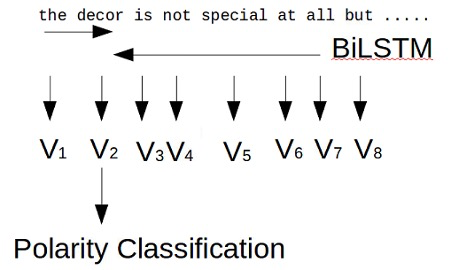

(This is a bit like a simplified version of the "unknown target" sequence tagging models discussed in lectures - but we're only trying to tag the one part of the sequence that we know corresponds to the aspect mention.)

In [ ]:
def aspect_mask(reviews, aspects, dataset):
  mask = []
  for review,aspect,data in zip(reviews, aspects, dataset):
    find_aspect = False
    for j in range(5):
      aspect_num = len(aspect)
      aspect_str = " ".join(aspect)
      aspect_len = int(len(aspect_str) - 1) * (j+1)
      offset = 0
      for i,r in enumerate(review):
        if i + aspect_num <= len(review):
          r_context = " ".join(review[i:i+aspect_num])
          if r_context == aspect_str and offset + aspect_len >  int(data[3]) and offset + aspect_len <  int(data[4]):
            find_aspect = True
            sentence_mask = [0] * len(review)
            sentence_mask[i:i+aspect_num] = [1] * aspect_num
            mask.append(sentence_mask)
            break
          else:
            offset += (len(r) + 1)
      if find_aspect:
        break

    if not find_aspect:
      for j in range(5):
        aspect_len = int(len(aspect_str) - 1) * (j+1)
        offset = 0
        for i,r in enumerate(review):
          if i + aspect_num <= len(review):
            r_context = " ".join(review[i:i+aspect_num])
            if r_context.startswith(aspect_str) and offset + aspect_len >  int(data[3]) and offset + aspect_len <  int(data[4]):
              find_aspect = True
              sentence_mask = [0] * len(review)
              sentence_mask[i:i+aspect_num] = [1] * aspect_num
              mask.append(sentence_mask)
              break
            else:
              offset += (len(r) + 1)
        if find_aspect:
          break

    if not find_aspect:
      for j in range(5):
        aspect_len = int(len(aspect_str) - 1) * (j+1)
        offset = 0
        for i,r in enumerate(review):
          if i + aspect_num <= len(review):
            r_context = " ".join(review[i:i+aspect_num])
            if r_context.endswith(aspect_str) and offset + aspect_len >  int(data[3]) and offset + aspect_len <  int(data[4]):
              find_aspect = True
              sentence_mask = [0] * len(review)
              sentence_mask[i:i+aspect_num] = [1] * aspect_num
              mask.append(sentence_mask)
              break
            else:
              offset += (len(r) + 1)
        if find_aspect:
          break

    if not find_aspect:
      print("annotation error:")
      print(data)
      sentence_mask = [0] * len(review)
      sentence_mask[16] = 1
      mask.append(sentence_mask)

    # if aspect_num > 1:
    #   print(mask[-1])

  return mask
x_train_aspect_mask = aspect_mask(x_train_review, x_train_aspect, train)
x_dev_aspect_mask = aspect_mask(x_dev_review, x_dev_aspect, val)
x_test_aspect_mask = aspect_mask(x_test_review, x_test_aspect, test)

print()
print()
print()
assert len(x_train_aspect_mask) == len(train)
assert len(x_test_aspect_mask) == len(x_test_aspect)

print(train[0])
print(x_train_aspect_mask[0])
print(train[1])
print(x_train_aspect_mask[1])
print(train[2])
print(x_train_aspect_mask[2])
print(train[3])
print(x_train_aspect_mask[3])
print(train[10319])
print(x_train_aspect_mask[10319])

annotation error:
['i love the food here, and although it is pricey, the entree comes with rice, naan, dal, and salad, which makes it worthwhile.', 'd al', 'neutral', '24', '28']



['the decor is not special at all but their food and amazing prices make up for it.', 'decor', 'negative', '4', '9']
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['the decor is not special at all but their food and amazing prices make up for it.', 'food', 'positive', '42', '46']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
['the decor is not special at all but their food and amazing prices make up for it.', 'prices', 'positive', '59', '65']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
['when tables opened up, the manager sat another party before us.', 'tables', 'neutral', '5', '11']
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['the scene there are two distinct personalities to the place: the loud, seemingly always-crowded bar with hanging paper decorations and dim lighting, and the two main dinin

In [ ]:
x_train_aspect_mask_pad = keras.preprocessing.sequence.pad_sequences(x_train_aspect_mask,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=128)
x_dev_aspect_mask_pad = keras.preprocessing.sequence.pad_sequences(x_dev_aspect_mask,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=128)
x_test_aspect_mask_pad = keras.preprocessing.sequence.pad_sequences(x_test_aspect_mask,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=128)
x_train_aspect_mask_pad[0]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
import tensorflow as tf

# your code goes here
# Tips: 
# 1) LSTM layer: Bidirectional(LSTM(100, return_sequences=True),name = 'BiLSTM')
# 2) Dot  layer: tf.keras.layers.Dot(axes=1)
# 3) Document of the Dot layer: https://keras.io/api/layers/merging_layers/dot/
# 4) dtype of the aspect input layer is float32

input_1 =Input(128, dtype='float32')
input_2 = Input(128, dtype='float32')
model4 = embeddingLayer(input_1)
model4 = Bidirectional(LSTM(100, return_sequences=True),name = 'BiLSTM')(model4)
model4 = Dot(axes=1)([model4, input_2])
model4 = Dense(16, activation="relu")(model4)
model4 = Dense(3, activation="softmax")(model4)
model4 = Model(inputs=[input_1, input_2], outputs=[model4])
model4.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 GloVe_Embeddings (Embedding)   (None, 128, 300)     120000300   ['input_9[0][0]']                
                                                                                                  
 BiLSTM (Bidirectional)         (None, 128, 200)     320800      ['GloVe_Embeddings[1][0]']       
                                                                                                  
 input_10 (InputLayer)          [(None, 128)]        0           []                               
                                                                                            

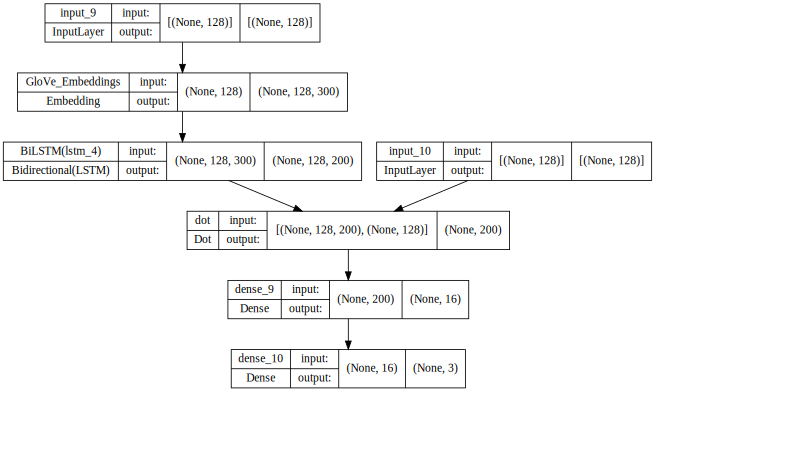

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model4, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  

In [ ]:
# your code goes here
model4.compile(optimizer='adam',
              loss= keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model4.fit([x_train_review_pad_glove, x_train_aspect_mask_pad],
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=([x_dev_review_pad_glove, x_dev_aspect_mask_pad], y_dev),
                    verbose=1)

results = model4.evaluate([x_test_review_pad_glove, x_test_review_pad_glove], y_test)
print(results)



Epoch 1/30
22/22 [==============================] - 37s 2s/step - loss: 0.9491 - accuracy: 0.5613 - val_loss: 0.8357 - val_accuracy: 0.6502
Epoch 2/30
22/22 [==============================] - 33s 1s/step - loss: 0.7862 - accuracy: 0.6657 - val_loss: 0.7617 - val_accuracy: 0.6704
Epoch 3/30
22/22 [==============================] - 33s 1s/step - loss: 0.6984 - accuracy: 0.7102 - val_loss: 0.7119 - val_accuracy: 0.7020
Epoch 4/30
22/22 [==============================] - 33s 2s/step - loss: 0.6347 - accuracy: 0.7384 - val_loss: 0.6864 - val_accuracy: 0.7192
Epoch 5/30
22/22 [==============================] - 33s 2s/step - loss: 0.5860 - accuracy: 0.7582 - val_loss: 0.6867 - val_accuracy: 0.7177
Epoch 6/30
22/22 [==============================] - 33s 2s/step - loss: 0.5480 - accuracy: 0.7812 - val_loss: 0.6710 - val_accuracy: 0.7177
Epoch 7/30
22/22 [==============================] - 33s 1s/step - loss: 0.5032 - accuracy: 0.7963 - val_loss: 0.6500 - val_accuracy: 0.7402
Epoch 8/30
22/22 [==